# Recommender Systems 2018/19

### Practice 3 - Content Based recommenders


### Load the data you saw last time:

In [1]:
from urllib.request import urlretrieve
import zipfile

# skip the download
#urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", "data/Movielens_10M/movielens_10m.zip")
dataFile = zipfile.ZipFile("data/Movielens_10M/movielens_10m.zip")
URM_path = dataFile.extract("ml-10M100K/ratings.dat", path = "data/Movielens_10M")
URM_file = open(URM_path, 'r')


def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))

userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)

import scipy.sparse as sps

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all = URM_all.tocsr()

URM_all

<71568x65134 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in Compressed Sparse Row format>

## And now load the content informations in the same way:
## In this case we are using tags

In [2]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = "data/Movielens_10M")
ICM_file = open(ICM_path, 'r')

def rowSplit (rowString):
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = str(split[2]) # tag is a string, not a float like the rating
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result

ICM_file.seek(0)
ICM_tuples = []

for line in ICM_file:
    ICM_tuples.append(rowSplit(line))
    
userList_icm, itemList_icm, tagList_icm, timestampList_icm = zip(*ICM_tuples)

userList_icm = list(userList_icm)
itemList_icm = list(itemList_icm)
tagList_icm = list(tagList_icm)
timestampList_icm = list(timestampList_icm)

userList_unique = list(set(userList_icm))
itemList_unique = list(set(itemList_icm))
tagList_unique = list(set(tagList_icm))

numUsers = len(userList_unique)
numItems = len(itemList_unique)
numTags = len(tagList_unique)


print ("Number of items\t {}, Number of users\t {}".format(numItems, numUsers))
print ("Number of tags\t {}, Number of item-tag tuples {}".format(numTags, len(tagList_icm)))

print("\nData example:")
print(userList_icm[0:10])
print(itemList_icm[0:10])
print(tagList_icm[0:10])

Number of items	 7601, Number of users	 4009
Number of tags	 16529, Number of item-tag tuples 95580

Data example:
[15, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[4973, 1747, 1747, 2424, 2424, 2424, 2947, 2947, 3033, 3033]
['excellent!', 'politics', 'satire', 'chick flick 212', 'hanks', 'ryan', 'action', 'bond', 'spoof', 'star wars']


### The numbers of items and users in the ICM matrix is different from what we saw in the URM, why?

### The tags are string, we should traslate them into numbers so we can use them as indices in the ICM

In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(tagList_icm)

tagList_icm = le.transform(tagList_icm)

print(tagList_icm[0:10])

[ 9814 13375 14131  8515 10769 14070  7015  8071 14829 14900]


# We can now build the ICM

In [4]:
import numpy as np
ones = np.ones(len(tagList_icm))
ICM_all = sps.coo_matrix((ones, (itemList_icm, tagList_icm)), shape=URM_all.shape)
ICM_all = ICM_all.tocsr()

ICM_all

<65131x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 71155 stored elements in Compressed Sparse Row format>

# Let's take a look at the ICM

In [6]:
features_per_item = (ICM_all > 0).sum(axis=1)
items_per_feature = (ICM_all > 0).sum(axis=0)

print(features_per_item.shape)
print(items_per_feature.shape)

(65134, 1)
(1, 16529)


In [7]:
features_per_item = np.array(features_per_item).squeeze()
items_per_feature = np.array(items_per_feature).squeeze()

print(features_per_item.shape)
print(items_per_feature.shape)

(65134,)
(16529,)


In [8]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

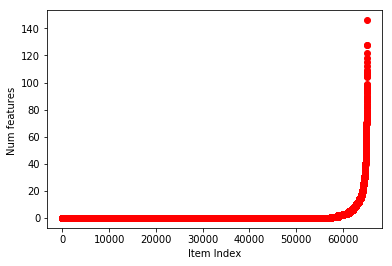

In [9]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Item Index')
pyplot.show()

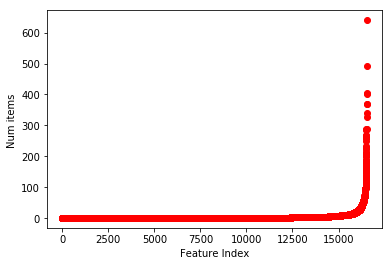

In [10]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Feature Index')
pyplot.show()

# We can now build the recommender algorithm, but first we need the train/test split and the evaluation function:

In [11]:
from Notebooks_utils.data_splitter import train_test_holdout


URM_train, URM_test = train_test_holdout(URM_all, train_perc = 0.8)


from Notebooks_utils.evaluation_function import evaluate_algorithm
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python


In [12]:
class ItemCBFKNNRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

### We need to define Cosine similarity... Let's look at the attached source code

## Test our CBF recommender:

In [13]:
recommender = ItemCBFKNNRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=50)

/home/maurizio/PycharmProjects/RecSys_Course_2018/Base/Similarity/Compute_Similarity_Python.py:249: RuntimeWarning: invalid value encountered in sqrt
  sumOfSquared = np.sqrt(sumOfSquared)


Similarity column 23500 ( 36 % ), 781.21 column/sec, elapsed time 0.50 min
Similarity column 46700 ( 72 % ), 775.98 column/sec, elapsed time 1.00 min
Similarity column 65100 ( 100 % ), 748.48 column/sec, elapsed time 1.45 min


In [14]:
for user_id in userList_unique[0:10]:
    print(recommender.recommend(user_id, at=5))

[8636 1591  153  173 6333]
[2947 2949 1687  544 2989]
[65133 21706 21719 21718 21717]
[ 6333 33493   260 31658  6350]
[8525 2566 5651 2043 1026]
[65133 21706 21719 21718 21717]
[65133 21706 21719 21718 21717]
[ 445   89 3081 6377 2043]
[ 4993  4963  3086 41566  7150]
[65133 21706 21719 21718 21717]


#### Let's talk about speed

#### Time to compute recommendations for a fixed group of users

In [15]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Reasonable implementation speed is 486.49 usr/sec


### Let's add a common mistake.... a CSC URM

In [16]:
URM_train_csc = URM_train.tocsc()

recommender = ItemCBFKNNRecommender(URM_train_csc, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 21300 ( 33 % ), 709.61 column/sec, elapsed time 0.50 min
Similarity column 43100 ( 66 % ), 716.75 column/sec, elapsed time 1.00 min
Similarity column 64100 ( 98 % ), 710.17 column/sec, elapsed time 1.50 min
Similarity column 65100 ( 100 % ), 708.74 column/sec, elapsed time 1.53 min


In [18]:
import time, traceback

try:

    n_users_to_test = 1000

    start_time = time.time()

    for user_id in range(n_users_to_test):
        recommender.recommend(user_id, at=5)

    end_time = time.time()

    print("Wrong implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

    
except Exception as e:
        
    print("Exception {}".format(str(e)))
    traceback.print_exc()


Exception index 65139 is out of bounds for axis 0 with size 65134


Traceback (most recent call last):
  File "<ipython-input-18-cd8883de5544>", line 10, in <module>
    recommender.recommend(user_id, at=5)
  File "<ipython-input-12-d625b194ca44>", line 23, in recommend
    scores = self.filter_seen(user_id, scores)
  File "<ipython-input-12-d625b194ca44>", line 38, in filter_seen
    scores[user_profile] = -np.inf
IndexError: index 65139 is out of bounds for axis 0 with size 65134


## Parameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Number of neighbors

In [20]:
x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemCBFKNNRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_k.append(result_dict["MAP"])

Similarity column 23300 ( 36 % ), 774.34 column/sec, elapsed time 0.50 min
Similarity column 49100 ( 75 % ), 816.99 column/sec, elapsed time 1.00 min
Similarity column 65100 ( 100 % ), 848.24 column/sec, elapsed time 1.28 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.1640, Recall = 0.0155, MAP = 0.1174
Similarity column 23500 ( 36 % ), 782.88 column/sec, elapsed time 0.50 min
Similarity column 47300 ( 73 % ), 787.26 column/sec, elapsed time 1.00 min
Similarity column 65100 ( 100 % ), 782.89 column/sec, elapsed time 1.39 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 7156

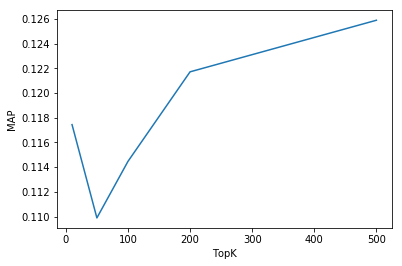

In [21]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors does not have a great impact on MAP. Higher values of TopK might work even better

#### Different datasets will behave in different ways.

### Shrinkage

In [22]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemCBFKNNRecommender(URM_train, ICM_all)
    recommender.fit(shrink=shrink, topK=100)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_shrinkage.append(result_dict["MAP"])

Similarity column 21400 ( 33 % ), 712.23 column/sec, elapsed time 0.50 min
Similarity column 43200 ( 66 % ), 718.83 column/sec, elapsed time 1.00 min
Similarity column 64300 ( 99 % ), 712.72 column/sec, elapsed time 1.50 min
Similarity column 65100 ( 100 % ), 713.81 column/sec, elapsed time 1.52 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.1542, Recall = 0.0145, MAP = 0.1145
Similarity column 20600 ( 32 % ), 686.10 column/sec, elapsed time 0.50 min
Similarity column 41800 ( 64 % ), 695.10 column/sec, elapsed time 1.00 min
Similarity column 62300 ( 96 % ), 691.15 column/sec, elapsed time 1.50 min
Similarity column 65100 ( 100 % ), 691.86 column/sec, elapsed time 1.57 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 7156

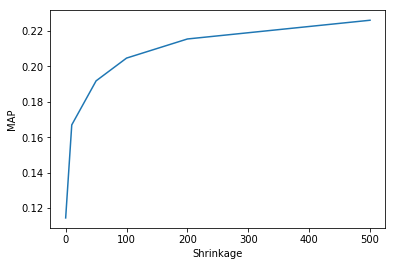

In [23]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### The shrinkage value (i.e. support) have a much stronger impact. Combine a parameter search with the two to ensure maximum recommendation quality

## Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# Feature weighting

# IDF

In [24]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = (ICM_all > 0).sum(axis=0)

IDF = np.array(np.log(num_tot_items / items_per_feature))[0]

print(ICM_all.shape)
print(IDF.shape)

(65134, 16529)
(16529,)


In [25]:
ICM_idf = ICM_all.copy()
# compute the number of non-zeros in each col
# NOTE: this works only if X is instance of sparse.csc_matrix
col_nnz = np.diff(sps.csc_matrix(ICM_idf).indptr)
print(col_nnz.shape)
print(ICM_idf.shape)
print(IDF.shape)
# then normalize the values in each col
ICM_idf.data *= np.repeat(IDF, col_nnz)

(16529,)
(65134, 16529)
(16529,)


In [26]:
recommender_idf = ItemCBFKNNRecommender(URM_train, ICM_idf)
recommender_idf.fit(shrink=0.0, topK=50)

evaluate_algorithm(URM_test, recommender_idf)

Similarity column 17700 ( 27 % ), 587.91 column/sec, elapsed time 0.50 min
Similarity column 35100 ( 54 % ), 582.73 column/sec, elapsed time 1.00 min
Similarity column 53100 ( 82 % ), 587.88 column/sec, elapsed time 1.51 min
Similarity column 65100 ( 100 % ), 588.41 column/sec, elapsed time 1.84 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.1499, Recall = 0.0140, MAP = 0.1114


{'precision': 0.14994705057385913,
 'recall': 0.013978810813171498,
 'MAP': 0.11144757052768182}

#### There is  a small gain over the non-weighted ICM. Try other feature weighting methods like BM25...

# Unnormalized similarity matrix

In [27]:

recommender_dot = ItemCBFKNNRecommender(URM_train, ICM_all)
recommender_dot.W_sparse = ICM_all * ICM_all.T

evaluate_algorithm(URM_test, recommender_dot)

Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.2990, Recall = 0.0281, MAP = 0.2442


{'precision': 0.2990211511492063,
 'recall': 0.028104306525581015,
 'MAP': 0.2441873336386661}